In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

2024-11-09 00:04:16.240599: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 00:04:16.243545: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 00:04:16.311573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 00:04:16.312921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 00:04:17.296181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
class MLP(RegressorMixin):
    def __init__(
        self,
        callbacks=None,
        validation_split=0.0,
    ):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0
        self.callbacks = callbacks
        self.validation_split = validation_split

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()

        # First Dense layer with Batch Normalization
        model.add(tf.keras.layers.Dense(units=256, activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())  # Add BatchNormalization
        model.add(tf.keras.layers.Dropout(rate=0.25))
        # Subsequent Dense layers with Batch Normalization
        model.add(tf.keras.layers.Dense(units=128, activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units=64, activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=32, activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units=16, activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))

        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )

        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

# Settings for Reproducibility

In [4]:
SEED = 47

<IPython.core.display.Javascript object>

In [5]:
def set_seeds(seed=SEED):
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [6]:
index_to_save = 10

<IPython.core.display.Javascript object>

In [7]:
weights_path = "../../../../../../../models/global_models/inn/mlp/inn/pre_training"
model_name = "mlp_chemical_properties_csless_vars_weights.h5"
full_path = os.path.join(weights_path, model_name)

<IPython.core.display.Javascript object>

In [8]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [9]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "partner_iv",
    "Plant": "partner_iv",
    "Features": "Chemical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "MLP",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [10]:
df = pd.read_csv(
    "../../../../../../../data/processed/partner_iv/cement-shipping_fine_tuning.csv"
)

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we use all available features

In [11]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "Factory_Plant",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [12]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [13]:
nan_cols = x.columns[x.isna().all()]
x[nan_cols] = x[nan_cols].fillna(0)

<IPython.core.display.Javascript object>

# 1. Multi Layer Perceptron

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 59 samples each
    2. 90% train (535 samples each fold)
    3. 10% test (59 samples each fold)
<b>Total:</b> 100 models<br>

In [14]:
# set_seeds()
# start = time.time()

# repeats = 3
# n_splits = 5
# pipeline = Pipeline(
#     [
#         ("imputer", SimpleImputer(strategy="median")),
#         ("transformer", StandardScaler()),
#         ("estimator", MLP()),
#     ]
# )
# cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
# scores = cross_validate(
#     pipeline,
#     x,
#     y,
#     scoring=METRICS,
#     cv=cv,
#     n_jobs=1,
#     return_train_score=True,
# )
# print("Repeated Cross Validation:")
# print(f"Repeats: {repeats}")
# print(f"n_splits: {n_splits}")
# print()
# print_scores(scores, METRICS, METRICS_DICT)

# results_dict_copy = results_dict.copy()
# results_dict_copy["Cross Validation"] = "Repeated KFold"
# results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
# results_dict_copy["Data Shape"] = x.shape
# df_results = fill_results_dict(results_dict_copy, scores)
# results_to_save.append(df_results)

# end = time.time()
# print("Minutes Elapsed: ", (end - start) / 60)

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 118 samples
    2. 50% train (59 samples each fold)
    3. 50% test (59 samples each fold)
<b>Total:</b> 5 models<br>

In [15]:
# set_seeds()
# start = time.time()

# repeats = 3
# n_splits = 5
# train_size = 0.8
# scores_final = None

# for _ in range(repeats):
#     pipeline = Pipeline(
#         [
#             ("imputer", SimpleImputer(strategy="median")),
#             ("transformer", StandardScaler()),
#             ("estimator", MLP()),
#         ]
#     )
#     cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
#     scores = cross_validate(
#         pipeline,
#         x,
#         y,
#         scoring=METRICS,
#         cv=cv,
#         # n_jobs=None,
#         return_train_score=True,
#     )
#     if scores_final is None:
#         scores_final = {key: [] for key, _ in scores.items()}

#     for key, value in scores.items():
#         scores_final[key] += [value]


# print("Blocking Time Series Split:")
# print(f"Repeats: {repeats}")
# print(f"n_splits: {n_splits}")
# print()
# print_scores(scores_final, METRICS, METRICS_DICT)

# scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
# results_dict_copy = results_dict.copy()
# results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
# results_dict_copy[
#     "Cross Validation Params"
# ] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
# results_dict_copy["Data Shape"] = x.shape
# df_results = fill_results_dict(results_dict_copy, scores)
# results_to_save.append(df_results)

# end = time.time()
# print("Minutes Elapsed: ", (end - start) / 60)

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (594, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 54, 108, 162, 216, 270, 324, 378, 432, 486 samples each fold
    2. Test: 54 samples each fold
<b>Total:</b> 10 models<br>

In [16]:
# set_seeds()
# start = time.time()

# scores_final = None
# repeats = 3
# n_splits = 5
# gap = 0

# for _ in range(repeats):
#     pipeline = Pipeline(
#         [
#             ("imputer", SimpleImputer(strategy="median")),
#             ("transformer", StandardScaler()),
#             ("estimator", MLP()),
#         ]
#     )
#     cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits)

#     scores = cross_validate(
#         pipeline,
#         x,
#         y,
#         scoring=METRICS,
#         cv=cv,
#         # n_jobs=-1,
#         return_train_score=True,
#     )
#     if scores_final is None:
#         scores_final = {key: [] for key, _ in scores.items()}
#     for key, value in scores.items():
#         scores_final[key] += [value]

# print("Blocking Time Series Split:")
# print(f"Repeats: {repeats}")
# print(f"n_splits: {n_splits}")
# print()
# print_scores(scores_final, METRICS, METRICS_DICT)

# # Saving the results
# scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
# results_dict_copy = results_dict.copy()
# results_dict_copy["Cross Validation"] = "Time Series Split"
# results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3, "Gap": 0}'
# results_dict_copy["Data Shape"] = x.shape
# df_results = fill_results_dict(results_dict_copy, scores)
# results_to_save.append(df_results)

# end = time.time()
# print("Minutes Elapsed: ", (end - start) / 60)

<IPython.core.display.Javascript object>

## 1.4. Out of time Split Cross Validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Train size: 80%</b><br>
<b>Test  size: 20%</b>


<b>Splits:</b> 2<br>    
    1. Train: 475
    2. Test: 118
<b>Total:</b> 1 model<br>

In [17]:
set_seeds()
start = time.time()

test_size = 0.5
repeats = 3
scores_final = None
preds = {}

print("Out of time Cross Val:")
print(f"Repeats: {repeats}")
print(f"Train: {50}%", f"Test: {50}%")
print()


for repeat in range(repeats):
    set_seeds(SEED + repeat)

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=SEED, shuffle=False
    )

    pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("transformer", StandardScaler()),
            ("estimator", MLP()),
        ]
    )

    pipeline.fit(x_train, y_train)

    y_train_pred = pipeline.predict(x_train)
    y_test_pred = pipeline.predict(x_test)

    scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

    if scores_final is None:
        scores_final = {key: [] for key, _ in scores.items()}

    for key, value in scores.items():
        scores_final[key] += [value]

    preds[repeat + 1] = {
        "pipeline": pipeline,
        "x_train": x_train,
        "x_test": x_test,
        "y_train": y_train,
        "y_test": y_test,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred,
    }

# Saving the results
results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Out of time Split"
results_dict_copy["Cross Validation Params"] = '{"Test Size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(
    results_dict_copy, {key: value for key, value in scores_final.items()}
)
results_to_save.append(df_results)

print_scores(scores_final, METRICS, METRICS_DICT)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Out of time Cross Val:
Repeats: 3
Train: 50% Test: 50%



2024-11-09 00:04:20.976151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-09 00:04:20.976202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: inspirada
2024-11-09 00:04:20.976212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: inspirada
2024-11-09 00:04:20.976378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-11-09 00:04:20.976410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-11-09 00:04:20.976418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


******
[TRAIN]
******
RMSE: 1.559 (0.014)
MAE: 1.169 (0.014)
MAPE: 0.025 (0.000)
R2: 0.949 (0.001)


******
[TEST]
******
RMSE: 3.901 (0.009)
MAE: 2.951 (0.026)
MAPE: 0.059 (0.001)
R2: 0.569 (0.002)


Minutes Elapsed:  0.8816896716753642


<IPython.core.display.Javascript object>

In [18]:
pd.concat(results_to_save).reset_index().groupby(
    ["Features", "Model", "Cross Validation"], dropna=False
)[["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
).round(
    2
)

Features Model   Cross Validation RMSE Test        \
                                                               mean   std   
0  Chemical + Properties CS Less   MLP  Out of time Split       3.9  0.01   

  MAE Test       MAPE Test      R2 Test       
      mean   std      mean  std    mean  std  
0     2.95  0.03      0.06  0.0    0.57  0.0

<IPython.core.display.Javascript object>

In [19]:
y_test = x_test = preds[1]["y_test"]
y_test_pred = []

for repeat in range(repeats):
    y_test_tmp = preds[repeat + 1]["y_test_pred"]  # .squeeze()
    y_test_pred.append(y_test_tmp)

y_test_pred = np.mean(np.array(y_test_pred), axis=0)
x_test = preds[1]["x_test"]

filtered_dates = dates[x_test.index]

# Step 2: Create a new dataframe with "Date", "CS28", and "CS28_PRED" columns
test_data = pd.DataFrame({
    'Date': pd.to_datetime(filtered_dates),
    'CS28': y_test.squeeze(),
    'CS28_PRED': y_test_pred.squeeze()
})


<IPython.core.display.Javascript object>

In [20]:
df_copy_merge = x_test.merge(test_data, left_index=True, right_index=True, how="left")

df_copy_merge["COMPANY"] = "Partner IV"
df_copy_merge["PLANT"] = "Partner IV"
# df_copy_merge["CS28_PRED"] = mean

df_copy_merge.to_excel("global_model_mlp_holdout_partnerIV.xlsx", index=False)
df_copy_merge.to_csv("global_model_mlp_holdout_partnerIV.csv", index=False)

<IPython.core.display.Javascript object>

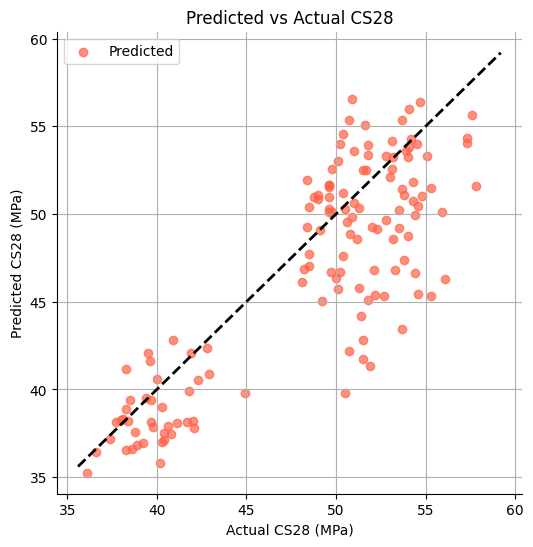

<IPython.core.display.Javascript object>

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [y.min(), y.max()],
    [y.min(), y.max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_partner_iv_global_fine_tuning_cm_p_mlp_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

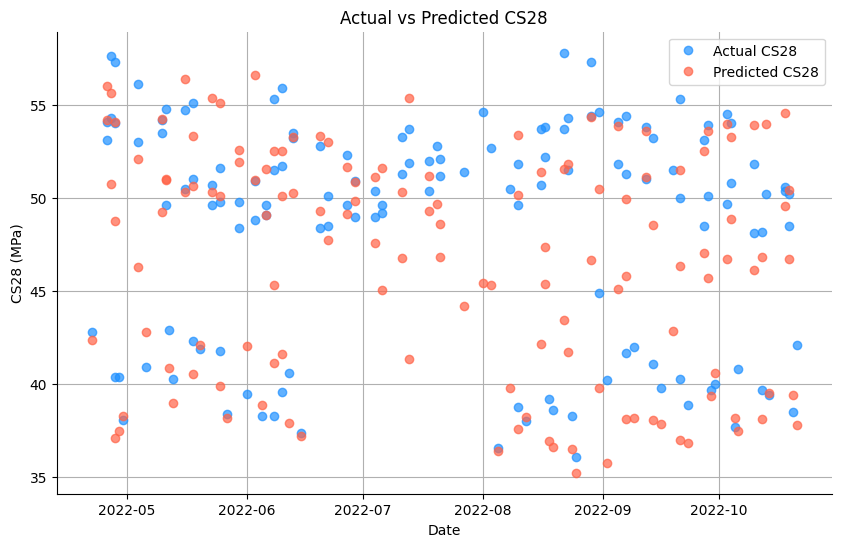

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["Date"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["Date"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_partner_iv_global_fine_tuning_cm_p_mlp_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [22]:
def permutation_importance_mlp(model, X, y, metric, n_repeats=5):
    """
    Computes permutation importance for MLP models with 2D input.
    """
    import numpy as np
    import pandas as pd

    baseline_score = metric(y, model.predict(X))
    num_features = X.shape[1]  # Number of features
    importances = np.zeros(num_features)
    set_seeds()

    for i in range(num_features):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across samples
            if isinstance(X_permuted, pd.DataFrame):
                # Use .iloc for integer-based indexing
                feature_values = X_permuted.iloc[:, i].copy()
                # Convert to NumPy array for shuffling
                feature_values_array = feature_values.values
                np.random.shuffle(feature_values_array)
                # Assign back to the DataFrame column
                X_permuted.iloc[:, i] = feature_values_array
            else:
                # If X_permuted is a NumPy array
                feature_values = X_permuted[:, i].copy()
                np.random.shuffle(feature_values)
                X_permuted[:, i] = feature_values
            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted))
            scores.append(permuted_score)
        # Importance is the decrease in performance when the feature is permuted
        importances[i] = baseline_score - np.mean(scores)
    return importances


<IPython.core.display.Javascript object>

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tqdm import tqdm

feature_importances = []

for repeat in preds.keys():
    x_test_seq = preds[repeat]["x_test"]
    y_test_seq = preds[repeat]["y_test"]
    estimator = preds[repeat]["pipeline"]

    # Compute permutation importance
    importances = permutation_importance_mlp(
        estimator, x_test_seq, y_test_seq, r2_score, n_repeats=10
    )
    feature_importances.append(importances)

<IPython.core.display.Javascript object>

In [24]:
import numpy as np
import pandas as pd

# Average importances across folds
mean_importances = np.mean(feature_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [25]:
rename_dict = {
    "Emiidrato": "Hemihydrate",
    "LOI": "Loss on Ignition",
    "2 days strenght": "CS1",
    "7 days strenght": "CS3",
    "28 days strenght": "CS28",
    "Belite_beta": "Beta C2S",
    "C3A cub": "Cubic C3A",
    "C3A_ortho": "Orthorhombic C3A",
    "C3A tot": "Total C3A",  # Changed to "Total C3A" and removed duplicate
    "Calcite – CaCO3": "CaCO3",  # Only one instance kept
    "SO3_XRD": "SO3 (XRD)",  # Only one instance kept
    "CO2_XRD": "CO2",  # Only one instance kept
    "tratt. 32 µm": "Sieve 32 um",  # Kept this final version
    "tratt. 40 µm": "Sieve 40 um",  # Kept this final version
    "residuo 24 micron": "Sieve 24 um",
    "data": "Date",  # Only one instance kept
    "Langbeinite – MgK2(SO4)2": "Langbeinite",  # Only one instance kept
    "Aphthitalite – (K,Na)3(SO4)2": "Aphthitalite",  # Only one instance kept
    "Gesso": "Gypsum",  # Only one instance kept
    "tratt. 63 µm": "Sieve 63 µm",  # Only one instance kept
    "Calce libera": "Free CaO",  # Only one instance kept
    "Periclasio (MgO)": "Periclase",  # Only one instance kept
    "Anidrite": "Anhydrite",  # Only one instance kept
    "Ratio_M1 (rapporto M1/M3)": "Ratio M1 M3",  # Corrected entry
    # "C3S_CS (taglia dei cristalliti C3S)": "C3S Crystal Size",  # Corrected entry
    "C3S_CS (taglia dei cristalliti C3S)": "C3S",  # Corrected entry
    "Alite_Sum C3S tot": "Total C3S",
    "Alite_M1 C3S M1": "C3S M1",  # Simplified name for M1 polymorph
    "Alite_M3 C3S M3": "C3S M3",  # Simplified name for M3 polymorph
}

importances_df = importances_df.rename(rename_dict, axis=1)

columns = {
    "C3S": r"$\mathrm{C_3S}$",
    "K2SO4": r"$\mathrm{K_2SO_4}$",
    "Periclase": "Periclase",
    "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
    "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
    "Total C3A": r"Total $\mathrm{C_3A}$",
    "Gypsum": "Gypsum",
    "C4AF": r"$\mathrm{C_4AF}$",
    "Langbeinite": "Langbeinite",
    "SO3": r"$\mathrm{SO_3}$",
    "Ratio M1 M3": "Ratio M1 M3",
    "Hemihydrate": "Hemihydrate",
    "Beta C2S": r"Beta $\mathrm{C_2S}$",
    "CO2": r"$\mathrm{CO_2}$",
    "Ca(OH)2": r"$\mathrm{Ca(OH)_2}$",
    "Aphthitalite": "Aphthitalite",
    "Quartz": "Quartz",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "CaCO3": r"$\mathrm{CaCO_3}$",
    "SO3 (XRD)": r"$\mathrm{SO_3}$ (XRD)",
    "CaO": r"$\mathrm{CaO}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "Anhydrite": "Anhydrite",
    "Cl-": r"$\mathrm{Cl}^-$",
    "C3S M3": r"$\mathrm{C_3S}$ M3",
    "C3S M1": r"$\mathrm{C_3S}$ M1",
    "Loss on Ignition": "LOI",
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "Loss on Ignition": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
}

importances_df = importances_df.rename(columns=columns)

importances_df_mean["Feature"] = (
    importances_df_mean["Feature"].replace(rename_dict).replace(columns)
)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


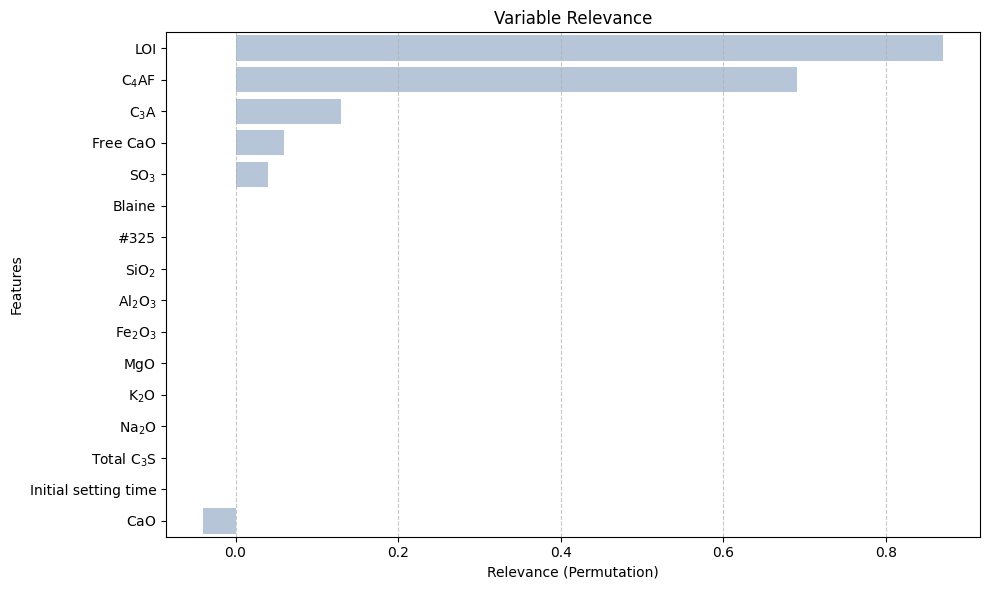

<IPython.core.display.Javascript object>

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Relevance")
plt.xlabel("Relevance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(
    "inn_partner_iv_global_fine_tuning_cm_p_mlp_best_mean_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

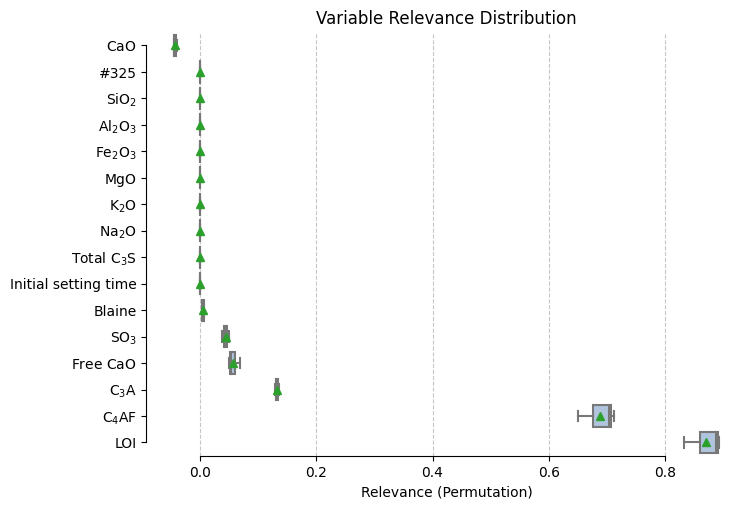

<IPython.core.display.Javascript object>

In [27]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_partner_iv_global_fine_tuning_cm_p_mlp_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [28]:
perm_importances_df

,$\mathrm{CaO}$,#325,$\mathrm{SiO_2}$,$\mathrm{Al_2O_3}$,$\mathrm{Fe_2O_3}$,$\mathrm{MgO}$,$\mathrm{K_2O}$,$\mathrm{Na_2O}$,Total $\mathrm{C_3S}$,Initial setting time,Blaine,$\mathrm{SO_3}$,Free $\mathrm{CaO}$,$\mathrm{C_3A}$,$\mathrm{C_4AF}$,LOI
0,-0.040573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007247,0.037811,0.068291,0.128753,0.650827,0.893348
1,-0.044156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002919,0.049750,0.053190,0.131147,0.712721,0.833261
2,-0.045398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004405,0.043552,0.049905,0.136307,0.702848,0.887676


<IPython.core.display.Javascript object>

# Saving the results Dataframe

## Saving the full dataframe

In [29]:
path = (
    f"../../../../../../../reports/results/global_models/inn_v2/partner_iv/fine_tuning/full/"
)
filename = f"mlp_results_full_{index_to_save}.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

## Saving the grouped dataframe

In [30]:
cols_groupby = [
    "Category",
    "Company",
    "Data Shape",
    "Timesteps",
    "Features",
    "Model",
    "Cross Validation",
    "Cross Validation Params",
]

cols_agg = ["RMSE Train", "MAE Train", "MAPE Train", "R2 Train"] + [
    "RMSE Test",
    "MAE Test",
    "MAPE Test",
    "R2 Test",
]

path = f"../../../../../../../reports/results/global_models/inn_v2/partner_iv/fine_tuning/grouped/"
filename = f"mlp_results_grouped_{index_to_save}.csv"


df_results_to_save = (
    pd.concat(results_to_save)
    .groupby(cols_groupby, dropna=False)[cols_agg]
    .agg(["mean", lambda series: pd.Series(series.std(ddof=0), name="std")])
    .reset_index()
    .rename(columns={"<lambda_0>": "std"})
)

df_results_to_save.to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

In [31]:
x.shape

(272, 16)

<IPython.core.display.Javascript object>